# Stock Price Trend Analysis

LSTM (Long-Short-term memory) is a powerful RNN architecture, capable of learning long-term dependencies.
In this project, we will predict stock price trend of the google stock price using  keras, tensorflow. 

Summarized steps are followings:

1. Extract, normailize and reshape the data that fits to the architecture.
2. Construct the architecture with various number of nodes(units) and layers. in our example, 50 nodes and 5 layers (3 hidden layers) have been used. 
3. Predict 30 days stock trend using the 5 years of historical prices fed into the LSTM model.
4. Visualize/compare the actual trend and the predicted trend.

5. Fianlly, add two extra dimensions, open and close prices, in an attempt to get more accurate trend.

## Part 1 - Data Preprocessing

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from datetime import datetime
from pandas_datareader.data import DataReader

In [2]:
# importing the training set
start = datetime(2012,1,1)
end = datetime(2016,12,31)

In [3]:
globals()['GOOG'] = DataReader('GOOG', 'yahoo', start, end)
df_train = GOOG
training_set = df_train.iloc[:,1:2].values

In [4]:
# Feature Scaling

In [5]:
# Apply Normailization

from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0,1))

# fit & transfrom (scale) it
sc_training_set = sc.fit_transform(training_set)


In [6]:
# Create a data structure with 60 timesteps and 1 output

X_train = []
y_train = []

# Start from 60 b/c we need 60 previous stock price to predict 61st stock price
for i in range(60,len(sc_training_set)):
    X_train.append(sc_training_set[i-60:i,:])
    # i =  t + 1
    y_train.append(sc_training_set[i,0])

In [7]:
# Change to arrays b/c RNN only accepts array form
X_train, y_train = np.array(X_train), np.array(y_train)

In [8]:
# Reshaping
# Add a new dimension (new indicator that might help the better prediction - like stock of other company)
# (batch-size, timesteps, number of indicators) = (X_train.shape(0), X_train.shape(1), X_train.shape[2]) = (1198,60,1)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],X_train.shape[2]))

## Part 2 - Building the LSTM model

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout


In [10]:
# Initialize the RNN

regressor = tf.keras.models.Sequential()

# return_sequences = True -> able to add other layers
# Add the first LSTM layer and some Dropout regularization
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1],X_train.shape[2])))
regressor.add(Dropout(0.2))

# Add the second LSTM layer 
# Don't need to specify the input_size after the input layer

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Add the third LSTM layer

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Add the fourth LSTM layer

regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

# Add the output layer
# Dense -> make a full connection
regressor.add(Dense(units = 1))

# Compiling the RNN
# adam optimizer is a safe choice for RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the training set
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)


Epoch 1/100
38/38 [==============================] - 13s 127ms/step - loss: 0.0413
Epoch 2/100
38/38 [==============================] - 5s 138ms/step - loss: 0.0062
Epoch 3/100
38/38 [==============================] - 5s 127ms/step - loss: 0.0061
Epoch 4/100
38/38 [==============================] - 5s 120ms/step - loss: 0.0051
Epoch 5/100
38/38 [==============================] - 5s 132ms/step - loss: 0.0055
Epoch 6/100
38/38 [==============================] - 5s 123ms/step - loss: 0.0054
Epoch 7/100
38/38 [==============================] - 5s 120ms/step - loss: 0.0051
Epoch 8/100
38/38 [==============================] - 5s 129ms/step - loss: 0.0044
Epoch 9/100
38/38 [==============================] - 5s 137ms/step - loss: 0.0045
Epoch 10/100
38/38 [==============================] - 6s 152ms/step - loss: 0.0044
Epoch 11/100
38/38 [==============================] - 6s 155ms/step - loss: 0.0044
Epoch 12/100
38/38 [==============================] - 5s 132ms/step - loss: 0.0044
Epoch 13/100

## Part 3 - Prediction

In [11]:
# import test data of Google Stock Price of January 2017
start_test = datetime(2017, 1, 1)
end_test = datetime(2017,1,31)
globals()['GOOG_test'] = DataReader('GOOG', 'yahoo', start_test, end_test)

df_test = GOOG_test
real_price = df_test.iloc[:,1:2].values

In [12]:
# Getting the predicted stock price of 2017
df_total = pd.concat([df_train.iloc[:,1:2], df_test.iloc[:,1:2]], axis = 0)
inputs =  df_total.iloc[len(df_total)-len(df_test) - 60:, :].values
# flatten dataframe into one column 
# inputs = inputs.reshape(-1,1)
# Scale the inputs
inputs = sc.transform(inputs)


In [13]:
X_test = []

# Start from 60 b/c we need 60 previous stock price to predict 61st stock price
for i in range(60,80):
    X_test.append(inputs[i-60:i, :])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))


In [14]:
predicted_price = regressor.predict(X_test)
# Make an empty df
temp = np.zeros((len(predicted_price),X_train.shape[2]))
for i in range(0, len(predicted_price)):
    temp[i,0] = predicted_price[i]

predicted_price = sc.inverse_transform(temp)[:,0]

## Part 4 - Visualization

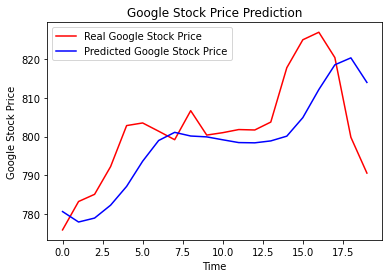

In [15]:
plt.plot(real_price, color = 'red', label = 'Real Google Stock Price')
plt.plot(predicted_price, color = 'blue', label = 'Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()

# Add new dimensions

We are now going to add two extra dimensions, open and close price of Google stock. The process is similar with some minor changes.

## Part 1 - Data Preprocessing

In [ ]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

In [17]:
# Importing the training set
start = datetime(2012,1,1)
end = datetime(2016,12,31)
globals()['GOOG'] = DataReader('GOOG', 'yahoo', start, end)
dataset_train = GOOG

# going to use open and close price of the stock
cols = 4
training_set = dataset_train.iloc[:, 1:cols].values


In [18]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

In [19]:
# Creating a data structure with 60 timesteps and 1 output
X_train = []
y_train = []
days=60

for i in range(days, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-days:i, :])
    y_train.append(training_set_scaled[i, 0])
X_train = np.array(X_train)
y_train = np.array(y_train)

## Part 2 - Building the LSTM model

In [26]:
# Importing the Keras libraries and packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

In [27]:
# Initialising the RNN
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
regressor.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)


Epoch 1/100
38/38 [==============================] - 14s 118ms/step - loss: 0.0356
Epoch 2/100
38/38 [==============================] - 4s 114ms/step - loss: 0.0070
Epoch 3/100
38/38 [==============================] - 5s 124ms/step - loss: 0.0055
Epoch 4/100
38/38 [==============================] - 5s 123ms/step - loss: 0.0054
Epoch 5/100
38/38 [==============================] - 5s 124ms/step - loss: 0.0052
Epoch 6/100
38/38 [==============================] - 5s 121ms/step - loss: 0.0048
Epoch 7/100
38/38 [==============================] - 5s 129ms/step - loss: 0.0049
Epoch 8/100
38/38 [==============================] - 5s 124ms/step - loss: 0.0056
Epoch 9/100
38/38 [==============================] - 4s 112ms/step - loss: 0.0045
Epoch 10/100
38/38 [==============================] - 5s 122ms/step - loss: 0.0042
Epoch 11/100
38/38 [==============================] - 5s 121ms/step - loss: 0.0046
Epoch 12/100
38/38 [==============================] - 5s 120ms/step - loss: 0.0045
Epoch 13/100

## Part 3 - Prediction

In [28]:
# Obtain the real stock price of January 2017
start_test = datetime(2017, 1, 1)
end_test = datetime(2017,1,31)
globals()['GOOG_test'] = DataReader('GOOG', 'yahoo', start_test, end_test)

dataset_test = GOOG_test
real_stock_price = dataset_test.iloc[:, 1:2].values

In [29]:
# Get the predicted stock price of 2017

dataset_total = dataset_train.append(dataset_test)
inputs = dataset_total.iloc[len(dataset_total) - len(dataset_test) - days:, 1:cols].values
inputs = sc.transform(inputs)

X_test = []
for i in range(days, days+len(dataset_test)):
    X_test.append(inputs[i-days:i, 0:cols])
X_test = np.array(X_test)

predicted_stock_price = regressor.predict(X_test)
temp = np.zeros((len(predicted_stock_price), cols-1))
for i in range(0, len(predicted_stock_price)):
    temp[i,0]=predicted_stock_price[i, 0]
    
predicted_stock_price = sc.inverse_transform(temp)[:,0]

## Part 4 - Visualision

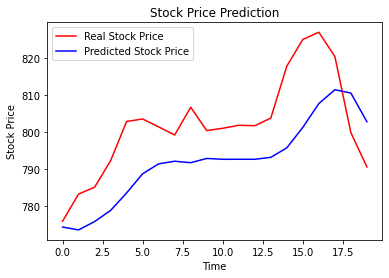

In [30]:
plt.plot(real_stock_price, color = 'red', label = 'Real Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()

Notice that the predicted 'prices' are a bit more deviated from the actual price than the first model.
However, the trend has been arguably better captured by adding two more dimensions.